In [161]:
import numpy as np
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym

In [162]:
env_name = "LunarLander-v2"

env = gym.make(env_name)
eval_env = gym.make(env_name)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [163]:
print("state size:", state_size)
print("action size:", action_size)

state size: 8
action size: 4


In [164]:
class PolicyNetwork(nn.Module):
	def __init__(self, in_dims, out_dims, hidden_size=128):
		super().__init__()  
		self.fc1 = nn.Linear(in_dims, hidden_size)
		self.fc2 = nn.Linear(hidden_size, out_dims)

		# initialize weights from a uniform distribution
		nn.init.uniform_(self.fc1.weight)
		nn.init.uniform_(self.fc2.weight)

	def forward(self, inputs):
		x = F.relu(self.fc1(inputs))
		x = F.relu(self.fc2(x))
		return F.softmax(x, dim=1)
      
	def act(self, state):
		state = torch.from_numpy(state).float().unsqueeze(0)
		probs = self.forward(state).cpu()
		model = Categorical(probs)
		action = model.sample()

		return action.item(), model.log_prob(action), model.entropy()

In [165]:
def evaluate(policy, n_eval_episodes=10, verbose=False):
	episode_rewards = []
	for _ in range(n_eval_episodes):
		state, _ = eval_env.reset()
		done = False
		total_rewards_ep = 0
		
		while True:
			action, _, _ = policy.act(state)

			if verbose: print(action)

			next_state, reward, done, truncated, _ = eval_env.step(action)
			total_rewards_ep += reward
			
			if done or truncated:
				break
			state = next_state
		episode_rewards.append(total_rewards_ep)
	mean_reward = np.mean(episode_rewards)
	std_reward = np.std(episode_rewards)

	return mean_reward, std_reward

In [166]:
def reinforce(policy, optimizer, n_training_episodes, gamma, eval_steps, max_timesteps=10_000, eta_entropy=0.01, verbose=False):
	eval_rewards = []
	eval_episodes = []
	
	for i_episode in range(1, n_training_episodes+1):
		saved_log_probs = []
		rewards = []
		entropies = []
		state, _ = env.reset()
		
		budget = 0
		while True or budget < max_timesteps:
			action, log_prob, entropy = policy.act(state)
			saved_log_probs.append(log_prob)
			state, reward, done, truncated, _ = env.step(action)
			rewards.append(reward)
			entropies.append(entropy)
			if done or truncated:
				break 
			budget += 1
		
		
		returns = deque(maxlen=max_timesteps) 
		T = len(rewards) 

		for t in range(T)[::-1]:
			# calculate the returns from T-1 to 0
			R_t = (returns[0] if len(returns)>0 else 0)
			returns.appendleft(gamma * R_t + rewards[t])    
			
		returns = torch.tensor(returns)
		
		# sum^{T-1}_{t=0} R_t * log \pi_\theta
		policy_loss = []

		for log_prob, R, entropy in zip(saved_log_probs, returns, entropies):
			# vanilla policy loss
			loss = -log_prob * R

			# entropy regularization
			loss -= entropy * eta_entropy

			policy_loss.append(loss)
			
		policy_loss = torch.stack(policy_loss)
		policy_loss = torch.sum(policy_loss, dim=0)

		# apply gradients
		optimizer.zero_grad()
		nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1)
		policy_loss.backward()
		optimizer.step()
		
		if i_episode % eval_steps == 0:
			mean_reward, std_reward = evaluate(policy)
			eval_rewards.append(mean_reward)
			eval_episodes.append(i_episode)

			if verbose:
				print("Episode", i_episode, "\tAverage Score:", mean_reward)
		
	return eval_rewards, eval_episodes

In [167]:
# hyperparameters
hidden_nodes = 64
n_training_episodes = 10_000 #10000
max_timesteps = 10_000
gamma = .99
learning_rate = 1e-3
entropy = 0.01

In [168]:
# policy = PolicyNetwork(state_size, action_size, hidden_nodes)
# optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

# # print(policy)
# scores, eval_episodes = reinforce(policy,
#                    optimizer,
#                    1000, 
#                    gamma, 
#                    100,
#                    max_timesteps,
#                    verbose=True)

# print(scores, eval_episodes)

# EVALUATION

In [169]:
from Helper import LearningCurvePlot, smooth
import time

def average_over_repetitions(n_repetitions, n_training_episodes, max_episode_length, learning_rate, hidden_nodes, gamma,
                            eta_entropy, smoothing_window=None, eval_interval=100):

	returns_over_repetitions = []
	now = time.time()
	for _ in range(n_repetitions): 
		policy = PolicyNetwork(state_size, action_size, hidden_nodes)
		optimizer = optim.Adam(policy.parameters(), lr=learning_rate)	
		
		eval_rewards, eval_episodes = reinforce(policy,
							optimizer,
							n_training_episodes, 
							gamma, 
							eval_interval,
							max_episode_length,
							eta_entropy,
							verbose=True)

		returns_over_repetitions.append(eval_rewards)
		
	print('Running one setting takes {} minutes'.format((time.time()-now)/60))
	learning_curve = np.mean(np.array(returns_over_repetitions),axis=0) # average over repetitions  
	if smoothing_window is not None: 
		learning_curve = smooth(learning_curve,smoothing_window) # additional smoothing
	return learning_curve, eval_episodes

Episode 100 	Average Score: -132.74904212806769
Episode 200 	Average Score: -138.76498088648128
Episode 300 	Average Score: -225.50897515122833
Episode 400 	Average Score: -119.93627834574723
Episode 500 	Average Score: -126.62757724812802
Episode 600 	Average Score: -176.9170813648854
Episode 700 	Average Score: -209.90572955238918
Episode 800 	Average Score: -84.38232529549539
Episode 900 	Average Score: -80.39773982425626
Episode 1000 	Average Score: -65.80288637993782
Episode 1100 	Average Score: -53.52244954880253
Episode 1200 	Average Score: -11.752374082324197
Episode 1300 	Average Score: -33.64719949054076
Episode 1400 	Average Score: -60.10546574132532
Episode 1500 	Average Score: -28.902912418522952
Episode 1600 	Average Score: -61.23514957145149
Episode 1700 	Average Score: -53.5571966596341
Episode 1800 	Average Score: -13.460476176146795
Episode 1900 	Average Score: -26.48327495909071
Episode 2000 	Average Score: 101.56880468681172
Episode 2100 	Average Score: 98.810998931

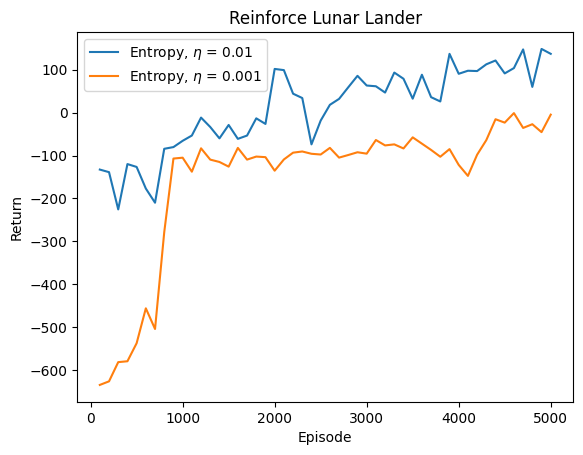

In [170]:
hidden_nodes = 64
n_training_episodes = 5_000 #10000
max_timesteps = 1_000
gamma = .99
learning_rate = 0.001

Plot = LearningCurvePlot(title = 'Reinforce Lunar Lander')    

entropies = [0.01, 0.001]
learning_rates = [0.01, 0.001] #TODO:
for entropy in entropies:        
	learning_curve, eval_episodes = average_over_repetitions(
      	1, 
		n_training_episodes, 
		max_timesteps, 
		learning_rate,
		hidden_nodes,
		gamma,
		entropy, 
		smoothing_window=None, 
		eval_interval=100)
	Plot.add_curve(eval_episodes, learning_curve, label=r'Entropy, $\eta$ = {}'.format(entropy))  

Plot.save('reinforce_lunar_lander.png')

In [171]:
# import os
# directory = os.path.join(os.getcwd(), "weights")

# # Check if the directory exists
# if not os.path.exists(directory):
#     # Create the directory if it doesn't exist
#     os.makedirs(directory)

# file_path = os.path.join(directory, f"model_nodes={hidden_nodes}_gamma={gamma}_lr={learning_rate}_entropy={entropy}.pth")
# torch.save(policy.state_dict(), file_path)

In [172]:
# env.close()
# eval_env.close()